In [ ]:
import csv
import os
import glob
import numpy
from PIL import ImageDraw 
from PIL import Image
import matplotlib.pyplot as plt
from PIL import ImageFont

def loadResizeImage(img_path, label=None):
    size = (124, 124)

    # Load the image
    img = Image.open(img_path)
    # Keep the original image size
    old_size = img.size

    # Compute resizing ratio
    ratio = float(size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Actually resize it
    img = img.resize(new_size, Image.ANTIALIAS)

    # Paste into centre of black padded image
    new_img = Image.new("RGB", (size[0], size[1]))
    new_img.paste(img, ((size[0] - new_size[0]) // 2, (size[1] - new_size[1]) // 2))
    if label != None:
        draw = ImageDraw.Draw(new_img)
        font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Arial.ttf", 12)
        draw.text((62, 10),label,(255,255,255),font=font)

    # Convert to numpy
    new_img = numpy.array(new_img, dtype=numpy.uint8)

    return new_img

# Function to compose images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img / 255 if horizontal == 1 else img for img in images],
    axis=horizontal,
)

def listDirs(dir):
    images = glob.glob(dir + '/*')
    timestamps = [os.path.getctime(path) for path in images]
    indeces = numpy.argsort(timestamps)
    images = [images[idx] for idx in indeces]
    return images, indeces


In [ ]:
# !pip3 install xlsxwriter

In [ ]:
# import xlsxwriter
# import cv2
# from io import BytesIO
# # This sorts images based on timestamps. These are used to manually annotate the dataset.
# topDir = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/test/*'
# dirs = glob.glob(topDir)
# for dir in dirs:
#     img, indeces = listDirs(dir)
#     # Create an new Excel file and add a worksheet.
#     workbook = xlsxwriter.Workbook('./tracklets/{}.xlsx'.format(dir.split('/')[-1]))
#     worksheet = workbook.add_worksheet()
#     sheetFormat = workbook.add_format({'text_wrap': True})
#     # Widen the first column to make the text clearer.
#     worksheet.set_column('A:A', 30, sheetFormat)
#     worksheet.set_column('B:B', 17)
#     for i in range(len(img)):
#         # Insert an image.
#         worksheet.set_row(i, 92)
#         success, img_numpy = cv2.imencode('.jpg', loadResizeImage(img[i], label=str(i)))
#         worksheet.write('A{}'.format(i), img[i])
#         worksheet.insert_image('B{}'.format(i), img[i], {'image_data': BytesIO(img_numpy.tobytes())})
#     workbook.close()

In [ ]:
# topDir = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/test/*'
# dirs = glob.glob(topDir)
# for dir in dirs:
#     img, indeces = listDirs(dir)
#     fig, ax = plt.subplots(1, figsize=((len(img) * 124)/500, 124/500), dpi=500)
#     img = [loadResizeImage(img[i], label=str(i)) for i in range(len(img))]
#     plt.imshow(compose(img, 1), aspect=1)
#     [ax.spines[spine].set_visible(False) for spine in ["top", "right", "bottom", "left"]]
#     ax.axes.get_xaxis().set_ticks([])
#     ax.axes.get_yaxis().set_ticks([])
#     ax.axis("tight")
#     # print("{} {}".format(dir, len(img)))
#     plt.savefig("./tracklets/{}.png".format(dir.split('/')[-1]), dpi=500)
#     plt.figure().clear()
#     plt.close()
#     plt.cla()
#     plt.clf()
#     # break

# Open cows 2020 tracklets

In [ ]:
import glob
import csv
import numpy
import json
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
# !pip3 install imblearn
from imblearn.over_sampling import SMOTE

def listDirs(dir):
    images = glob.glob(dir + '/*')
    timestamps = [os.path.getctime(path) for path in images]
    indeces = numpy.argsort(timestamps)
    images = [images[idx] for idx in indeces]
    return images, indeces

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

topDir = './tracklets/train/csv/*'
dirs = glob.glob(topDir)
dataSet = {"test": [], "train": [], "valid": []}
ignoreIndex = 1000
for dir in dirs:
    # Parse the train data
    with open(dir) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        data = []
        trackletInd = []
        for row in csv_reader:
            row[0] = row[0].replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '')
            category = int(row[0].split('/')[-2])
            if category < ignoreIndex:
                data.append([row[0], category, int(row[1])])
                trackletInd.append(int(row[1]))

        dataRow = []
        for i in range(len(numpy.unique(trackletInd))):
            dataRow += [{'paths':[], 'label': ''}]
        for path, category, tracklet in data:
            dataRow[tracklet]['label'] = category
            dataRow[tracklet]['paths'].append(path)
        dataSet['train'] += dataRow

# Append data from the test set file
topDIR = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/test/'
with open('utils/openCows2020_test_tracklet.json') as f:
    files = json.load(f)
    for file in files:
        if file['type'] == 'split':
            directories, indeces = listDirs(topDIR + file['cowID'])
            for split in file['splits']:
                if int(file['cowID']) < ignoreIndex:
                    sortedIdx = [directories[idx].replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for idx in split]
                    dataSet['train'].append({"label": int(file['cowID']), "paths": sortedIdx})
        else:
            if int(file['cowID']) < ignoreIndex:
                directories, indeces = listDirs(topDIR + file['cowID'])
                directories = [director.replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for director in directories]
                dataSet['train'].append({"label": int(file['cowID']), "paths": directories})

# Lets devide the sequences into smaller sequences of length 5
data = []
for tracklet in dataSet['train']:
    label = tracklet['label'] - 1
    subsequences = list(chunks(tracklet['paths'], 5))
    sequences = []
    for sequence in subsequences:
        sequence = {'paths': sequence, 'label': label}
        sequences.append(sequence)
    data += sequences

labels = [tracklet['label'] for tracklet in  data]
# Now let make the test and train split
train, test, _, _ = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)
dataSetFin = {"test": test, "train": train, "valid": []}

# Generate k folds validation set
sKFold = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
i = 0
for train_index, test_index in sKFold.split(dataSetFin['train'], [tracklet['label'] for tracklet in  dataSetFin['train']]):
    train, test = [], []
    for j in range(len(train_index)):
        train.append(dataSetFin['train'][train_index[j]])
    for j in range(len(test_index)):
        test.append(dataSetFin['train'][test_index[j]])

    dataSetFin['traink{}'.format(i)] = train
    dataSetFin['testk{}'.format(i)] = test
    i+=1

import json
# Save
with open('./utils/opencowsTracklets2020.json', 'w') as fp:
    json.dump(dataSetFin, fp)

In [ ]:
import matplotlib.pyplot as plt
classFrequency = numpy.zeros(numpy.unique(labels).shape)

def labels_to_class_weights(labels, nc=80): 
    # Get class weights (inverse frequency) from training labels 
    classes = numpy.asarray(labels)
    weights = numpy.bincount(classes, minlength=nc)  # occurences per class 
    weights[weights == 0] = 1  # replace empty bins with 1 
    weights = 1 / weights  # number of targets per class 
    weights /= weights.sum()  # normalize 
    return weights

for track in dataSetFin['traink0']:
    classFrequency[track['label']] += 1

# for track in data:
#     classFrequency[track['label']] += 1

plt.rcParams["figure.figsize"] = (15, 5)
width = 0.40
x = numpy.unique(labels)
ax = plt.axes()
# plt.bar(x-0.2, classFrequency, width, color='cyan')
plt.bar(x-0.2, classFrequency / numpy.sum(classFrequency), width, color='cyan')
plt.bar(x+0.2, labels_to_class_weights(labels, nc=len(x)), width, color='green')

ax.set_xticks(x)
ax.set_xticklabels(['$C_{{{}}}$'.format(i) for i in x])
plt.xlabel("Individual")
plt.ylabel("Number of Samples")
plt.legend(["Class frequency", "Weights"])
plt.show()

In [ ]:
import json
topDIR = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/train/'
dataSet = {"test": [], "train": [], "valid": []}
with open('utils/openCows2020_train_tracklet.json') as f:
    files = json.load(f)
    for file in files:
        if file['type'] == 'split':
            directories, indeces = listDirs(topDIR + file['cowID'])
            for split in file['splits']:
                sortedIdx = [directories[idx].replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for idx in split]
                dataSet['train'].append({"label": int(file['cowID']), "paths": sortedIdx})
        else:
            directories, indeces = listDirs(topDIR + file['cowID'])
            directories = [director.replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for director in directories]
            dataSet['train'].append({"label": int(file['cowID']), "paths": directories})

topDIR = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/test/'
with open('utils/openCows2020_test_tracklet.json') as f:
    files = json.load(f)
    for file in files:
        if file['type'] == 'split':
            directories, indeces = listDirs(topDIR + file['cowID'])
            for split in file['splits']:
                sortedIdx = [directories[idx].replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for idx in split]
                dataSet['test'].append({"label": int(file['cowID']), "paths": sortedIdx})
        else:
            directories, indeces = listDirs(topDIR + file['cowID'])
            directories = [director.replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for director in directories]
            dataSet['test'].append({"label": int(file['cowID']), "paths": directories})


In [ ]:
dt = [len(track['paths']) for track in dataSet['test']]
plt.plot(dt)

# 2021 dataset

In [ ]:
import csv
import os
import glob
import numpy
from sklearn.model_selection import train_test_split

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def listDirs(dir):
    images = glob.glob(dir + '/*')
    timestamps = [os.path.getctime(path) for path in images]
    indeces = numpy.argsort(timestamps)
    images = [images[idx] for idx in indeces]
    return images

topDir = '/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB'
dataSet = {"test": [], "train": [], "valid": []}

# Parse the train data
with open('utils/correct.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count > 0 and line_count < 465 and row[6] != 'black':
            label = row[4] if row[4] != '' else row[2]
            if label != '':
                dirs = [dir.replace('/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/', '') for dir in listDirs(os.path.join(topDir, row[1]))]
                # Split into smaller sequences
                subsequences = list(chunks(dirs, 10))
                subsequences = [
                    {'paths': subsequence, 'label': int(label)}
                    for subsequence in subsequences
                ]
                dataSet['train'] += subsequences
        line_count += 1

# Parse the test data
labels = list(set([item['label'] for item in dataSet["train"]]))
topDir = '/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Identification/Test/'
for label in labels:
    path = os.path.join(topDir, '{:>03}'.format(label))
    dirs = [dir.replace('/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/', '') for dir in listDirs(path)]
    # Split into smaller sequences
    subsequences = list(chunks(dirs, 10))
    subsequences = [
        {'paths': subsequence, 'label': int(label)}
        for subsequence in subsequences
    ]
    dataSet['test'] += subsequences    
    # dataSet["test"].append({'label': int(label), 'paths': dirs})

# Since we omitted black cows we need to remove some classes and reindex the labels again
labels = list(set([item['label'] for item in dataSet["train"]] + [item['label'] for item in dataSet["test"]]))
hotEncodeMap = {}
for i in range(len(labels)):
    hotEncodeMap[labels[i]] = i

# Now we can use the map the relabel the dataset
for split in dataSet.keys():
    for i in range(len(dataSet[split])):
        dataSet[split][i]['label'] = hotEncodeMap[dataSet[split][i]['label']]

# Prepare for k-fold splits
data = dataSet['train'] + dataSet['test']
labels = [item['label'] for item in data]

from sklearn.model_selection import StratifiedKFold

# Generate k folds validation set
sKFold = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
dataSetFin = {"test": [], "train": [], "valid": []}
i = 0
for train_index, test_index in sKFold.split(data, labels):
    train, test = [], []
    for j in range(len(train_index)):
        train.append(data[train_index[j]])
    for j in range(len(test_index)):
        test.append(data[test_index[j]])
    dataSetFin['traink{}'.format(i)] = train
    dataSetFin['testk{}'.format(i)] = test
    i+=1

# Now let make the test and train split
train, test, _, _ = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)
dataSetFin['train'] = train
dataSetFin['test'] = test

import json
# Save
with open('./utils/opencowsTracklets2021.json', 'w') as fp:
    json.dump(dataSetFin, fp)

In [ ]:
import matplotlib.pyplot as plt
classFrequency = numpy.zeros(numpy.unique(labels).shape)

def labels_to_class_weights(labels, nc=80): 
    # Get class weights (inverse frequency) from training labels 
    classes = numpy.asarray(labels)
    weights = numpy.bincount(classes, minlength=nc)  # occurences per class 
    weights[weights == 0] = 1  # replace empty bins with 1 
    weights = 1 / weights  # number of targets per class 
    weights /= weights.sum()  # normalize 
    return weights

for track in dataSetFin['traink0']:
    classFrequency[track['label']] += 1

plt.rcParams["figure.figsize"] = (15, 5)
width = 0.40
x = numpy.unique(labels)
ax = plt.axes()
# plt.bar(x-0.2, classFrequency, width, color='cyan')
plt.bar(x-0.2, classFrequency / numpy.sum(classFrequency), width, color='cyan')
plt.bar(x+0.2, labels_to_class_weights(labels, nc=len(x)), width, color='green')

ax.set_xticks(x)
ax.set_xticklabels(['$C_{{{}}}$'.format(i) for i in x])
plt.xlabel("Individual")
plt.ylabel("Number of Samples")
plt.legend(["Class frequency", "Weights"])
plt.show()

# Timestamp for 2021 dataset


In [ ]:
import re
from datetime import datetime

def fp2timestamp(fp):
    # Regex pattern to match the timestamp
    pattern = r'_?(?P<YY>\d{4})-(?P<MM>\d{2})-(?P<DD>\d{1,2})_(?P<hh>\d{1,2})-(?P<mm>\d{1,2})-(?P<ss>\d{1,2})_(image_roi|roi)'
    # Get groups
    try:
        p = list(re.finditer(pattern, fp))[0].groupdict()
        # Convert to datetime object
        p = f"{p['YY']}-{p['MM']}-{(p['DD'])}T{p['hh']}::{p['mm']}::{p['ss']}"
        return datetime.timestamp(datetime.strptime(p, '%Y-%m-%dT%H::%M::%S'))
    except IndexError:
        return 0
for tracklet in dataSet['train']:
    [fp2timestamp(path) for path in tracklet['paths']]

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def loadResizeImage(img_path):
    size = (244, 244)
    # Load the image
    img = Image.open(img_path)

    # Keep the original image size
    old_size = img.size

    # Compute resizing ratio
    ratio = float(size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Actually resize it
    img = img.resize(new_size, Image.ANTIALIAS)

    # Paste into centre of black padded image
    new_img = Image.new("RGB", (size[0], size[1]))
    new_img.paste(img, ((size[0] - new_size[0]) // 2, (size[1] - new_size[1]) // 2))

    # Convert to numpy
    new_img = numpy.array(new_img, dtype=numpy.uint8)

    return new_img

# Function to compose images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img / 255 if horizontal == 1 else img for img in images],
    axis=horizontal,
)

topDir = "/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17"
for i in range(38, 39):
    # Sample image from the dataset
    trainSet = None
    testSet = None
    negSet = None
    for j in range(len(dataSet["train"])):
        if dataSet["train"][j]["label"] - 1 == i:
            trainSet = dataSet["train"][j]["paths"]
            break
    for j in range(len(dataSet["test"])):
        if dataSet["test"][j]["label"] - 1 == i:
            testSet = dataSet["test"][j]["paths"]
            break
    for j in range(len(dataSet["test"])):
        if dataSet["test"][j]["label"] - 1 == i+1:
            negSet = dataSet["test"][j]["paths"]
            break
    # Take first 5 images
    trainSet, testSet, negSet = [os.path.join(topDir, path) for path in trainSet[:5]], [
        os.path.join(topDir, path) for path in testSet[:5]
    ], [os.path.join(topDir, path) for path in negSet[:5]]

    trainSet, testSet = [loadResizeImage(path) for path in trainSet], [loadResizeImage(path) for path in testSet]
    negSet = [loadResizeImage(path) for path in negSet]
    print(len(trainSet), len(testSet), len(negSet))
    composite = compose([compose(trainSet, 1), compose(testSet, 1), compose(negSet, 1)], 0)
    plt.imshow(composite)
    plt.show()
    print(i)
    break

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(1, dpi=100)
found = []
for item in dataSet['train']:
    if item['label'] == 1:
        found.append(item)

# Take first 5 images
trainSet, testSet = [os.path.join(topDir, path) for path in found[0]['paths'][:5]], [
    os.path.join(topDir, path) for path in found[1]['paths'][:5]
]

trainSet, testSet = [loadResizeImage(path) for path in trainSet], [loadResizeImage(path) for path in testSet]
composite = compose([compose(trainSet, 1), compose(testSet, 1)], 0)
plt.imshow(composite)
plt.show()


In [ ]:
import json
# Save
with open('./utils/opencowsTracklets2020V2.json', 'w') as fp:
    json.dump(dataSet, fp)

In [ ]:
dt = [len(track['paths']) for track in dataSet['train']]
plt.plot(dt)
sum(dt) / len(dt)

In [ ]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
import hiddenlayer as hl
from tqdm import tqdm
from torch import optim
import numpy
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from utils.OpenSetCows2021 import OpenSetCows2021TrackLet

dataset = OpenSetCows2021TrackLet(
    "/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17",
    "utils/opencowsTracklets2020V2.json",
    maxSequenceLength=None,
    transform=False,
    split="train",
    trackletChoiceProb = 1,
)

dataset2 = OpenSetCows2021TrackLet(
    "/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17",
    "utils/opencowsTracklets2020V2.json",
    maxSequenceLength=None,
    transform=False,
    split="test",
    trackletChoiceProb = 1,
)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

distribution = numpy.asarray([[k, len(dataset.lookup[k])] for k in dataset.lookup.keys()])
distribution2 = numpy.asarray([[k, len(dataset2.lookup[k])] for k in dataset2.lookup.keys()])
langs = [str(i) for i in distribution[:,0]]
students = distribution[:,1]
ax.bar(langs,students)
ax.bar(langs,distribution2[:,1])
plt.show()

dataset3 = OpenSetCows2021TrackLet(
    "/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17",
    "utils/opencowsTracklets2020V2Combined.json",
    maxSequenceLength=None,
    # transform=False,
    split="train",
    trackletChoiceProb = 1,
)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
distribution = numpy.asarray([[k, len(dataset3.lookup[k])] for k in dataset3.lookup.keys()])
langs = [str(i) for i in distribution[:,0]]
students = distribution[:,1]
ax.bar(langs,students)
plt.show()

In [ ]:
sequenceLengths = [[dataset3.__getitem__(ind)[0].shape[0] for ind in dataset3.lookup[k]] for k in dataset3.lookup.keys()]
sequenceLengths

# Make k-fold validation dataset for AirealCows 2017

In [ ]:
import json, glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

topDIR = '/Users/as16542/Downloads/3owflku95bxsx24643cybxu3qh/*/*/*.jpg'
dataSet = {"test": [], "train": [], "valid": []}
images = glob.glob(topDIR)
images.sort()
currentCategory, currentTracklet = 0, 0
currentList, trackletImage = [], []
element = {}
categories = []
for directory in images:
    elements = directory.split('/')
    category, tracklet, image = int(elements[-3]), int(elements[-2]), elements[-1]
    if currentCategory != category or currentTracklet != tracklet:
        dataSet['train'].append({'paths': trackletImage, 'label': currentCategory})
        trackletImage = []
        categories.append(category)
        currentCategory = category
        currentTracklet = tracklet
    # if category > 1:
    #     break
    trackletImage.append(directory.replace('/Users/as16542/Downloads/3owflku95bxsx24643cybxu3qh/', ''))

def list_splitter(list_to_split, ratio):
    first_half = int(len(list_to_split) * ratio)
    return list_to_split[:first_half], list_to_split[first_half:]

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

dataSetFin = {"test": [], "train": [], "valid": []}
data = []
for category in list(set(categories)):
    tracklets = []
    for tracklet in dataSet['train']:
        if tracklet['label'] == category:
            subsequences = list(chunks(tracklet['paths'], 10))
            # subsequences = [subsequence for subsequence in subsequences if len(subsequence) >= 5]
            subsequences = [
                {'paths': subsequence, 'label': category}
                for subsequence in subsequences
            ]
            tracklets+=subsequences
    data += tracklets

labels = [tracklet['label'] for tracklet in  data]
train, test, _, _ = train_test_split(data, labels, test_size=0.2, random_state=42)
dataSetFin['train'] = train
dataSetFin['test'] = test

from sklearn.model_selection import StratifiedKFold

# Generate k folds validation set
sKFold = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
i = 0
for train_index, test_index in sKFold.split(dataSetFin['train'], [tracklet['label'] for tracklet in  dataSetFin['train']]):
    train, test = [], []
    print(train_index[:10], test_index[:10])
    for j in range(len(train_index)):
        train.append(dataSetFin['train'][train_index[j]])
    for j in range(len(test_index)):
        test.append(dataSetFin['train'][test_index[j]])
    dataSetFin['traink{}'.format(i)] = train
    dataSetFin['testk{}'.format(i)] = test
    i+=1

import json
# Save
with open('./utils/opencowsTracklets2017.json', 'w') as fp:
    json.dump(dataSetFin, fp)

In [ ]:
import json
from utils.OpenSetCows2021 import OpenSetCows2021TrackLet
import numpy
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from utils.classWeights import ClassWeights
import math

batchSize = 25
trainingDataset = OpenSetCows2021TrackLet(
    "/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17",
    'utils/opencowsTracklets2020.json',
    maxSequenceLength=5,
    split='traink2',
    trackletChoiceProb = 0.4,
    eval=False,
    batchSize=batchSize
)

trainingDataLoader = DataLoader(
    trainingDataset, batch_size=batchSize, num_workers=2, shuffle=True
)

# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# distribution = numpy.asarray([[k, len(trainingDataset.lookup[k])] for k in trainingDataset.lookup.keys()])
# langs = [str(i) for i in distribution[:,0]]
# students = distribution[:,1] 
# ax.bar(langs,students)
# plt.show()

with open('utils/opencowsTracklets2020.json') as f:
    dataSet = json.load(f)

import matplotlib.pyplot as plt
classFrequency = []
for track in dataSet['train']:
    classFrequency.append(track['label'])

for track in dataSet['test']:
    classFrequency.append(track['label'])

print('ClassFrequency')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = list(range(trainingDataset.numClasses))
langs = [str(l) for l in langs]
ax.bar(langs, trainingDataset.classFrequency)
plt.show()

print('SKlearn')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
weights = compute_class_weight(class_weight = 'balanced', classes = numpy.unique(classFrequency), y = classFrequency)

# weights /= (numpy.sum(weights) * len(langs))
ax.bar(langs, weights)
plt.show()

print('Effective Number of Samples')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
weights = ClassWeights(trainingDataset.classFrequency, trainingDataset.numClasses, 'ENS', beta=0.89, normalise=False)()
ax.bar(langs, weights)
plt.show()

print('Inverse Number of Samples')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
weights = ClassWeights(trainingDataset.classFrequency, trainingDataset.numClasses, 'INS')()
ax.bar(langs, weights)
plt.show()

print('Inverse Squareroot of Number of Samples')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
weights = ClassWeights(trainingDataset.classFrequency, trainingDataset.numClasses, 'ISNS')()
ax.bar(langs, weights)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.plot([i%23 for i in range(92)])

betaForENS = numpy.linspace(0.999, 0.92, 50)

for i in range(len(betaForENS)):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title(r"$\beta=${}, iteration: {}".format(betaForENS[i], i))
    weights = ClassWeights(trainingDataset.classFrequency, trainingDataset.numClasses, 'ENS', beta=betaForENS[i], normalise=False)() * 100
    ax.bar(langs, weights)
    plt.show()

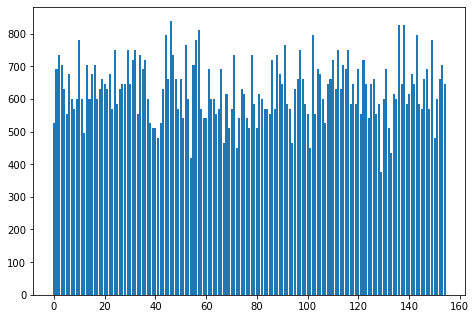

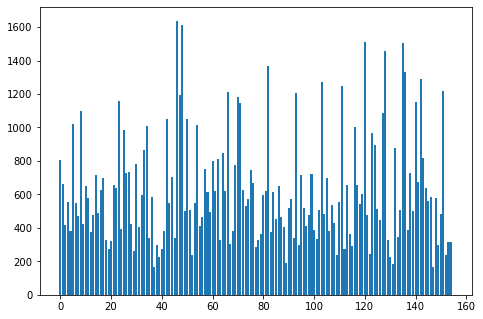

In [10]:
from pytorch_metric_learning.samplers import MPerClassSampler
import matplotlib.pyplot as plt
from utils.OpenSetCows2021 import OpenSetCows2021TrackLet
from torch.utils.data.sampler import Sampler
from pytorch_metric_learning.utils import common_functions as c_f
import random
from torch.utils.data import DataLoader
import numpy
import torch
from utils.classWeights import ClassWeights
from copy import deepcopy

class MPerClassTripletSampler(Sampler):
  def __init__(self, labels, m, batch_size=None, weights=None, length_before_new_iter=100000):
    self.posSampler = MPerClassSampler(labels, m=m, length_before_new_iter=length_before_new_iter, batch_size=batch_size)
    self.weights = None
    if isinstance(weights, numpy.ndarray):
        self.weights = torch.as_tensor(weights, dtype=torch.double)

  def __len__(self):
    return self.posSampler.list_size

  def __iter__(self):
      idx_listPos = [0] * self.posSampler.list_size
      idx_listNeg = [0] * self.posSampler.list_size
      i = 0
      num_iters = self.posSampler.calculate_num_iters()
      for _ in range(num_iters):
          c_f.NUMPY_RANDOM.shuffle(self.posSampler.labels)
          curr_label_set_neg = deepcopy(self.posSampler.labels)

          if self.posSampler.batch_size is None:
              curr_label_set = self.posSampler.labels
              c_f.NUMPY_RANDOM.shuffle(curr_label_set_neg)
          else:
              curr_label_set = self.posSampler.labels[: self.posSampler.batch_size // self.posSampler.m_per_class]
              
              for l in curr_label_set:
                curr_label_set_neg = list(filter(lambda val: val !=  l, curr_label_set_neg) )
              curr_label_set_neg = curr_label_set_neg[: self.posSampler.batch_size // self.posSampler.m_per_class]
              
              if self.weights != None:
                  weightedIndeces = torch.multinomial(self.weights[curr_label_set_neg], len(curr_label_set_neg), True)
                  curr_label_set_neg = [curr_label_set_neg[index] for index in list(weightedIndeces.numpy())]
              # Remove the anchors from the negative set

          for label in curr_label_set:
              t = self.posSampler.labels_to_indices[label]
              idx_listPos[i : i + self.posSampler.m_per_class] = c_f.safe_random_choice(
                  t, size=self.posSampler.m_per_class
              )

              # Remove the anchors from the negative set
              negatives = curr_label_set_neg
              if self.posSampler.batch_size is None:
                  negatives = list(filter(lambda val: val !=  t[0], negatives))

              # Assign choice weights
              if isinstance(self.weights, numpy.ndarray):
                  weightsForSamplingNeg = self.weights[curr_label_set_neg]
              else:
                  weightsForSamplingNeg = None

              tex = random.choices(negatives, weights=weightsForSamplingNeg, k=self.posSampler.m_per_class)

              # Assert the the anchor does not appear in the negatives list
              assert((t[0] not in tex) == True)
              idx_listNeg[i : i + self.posSampler.m_per_class] = tex
              i += self.posSampler.m_per_class
    #   print(idx_listPos, idx_listNeg)
      return iter(zip(idx_listPos, idx_listNeg))

trainingDataset = OpenSetCows2021TrackLet(
    "/Users/as16542/Downloads/3owflku95bxsx24643cybxu3qh",
    "./utils/opencowsTracklets2021.json",
    maxSequenceLength=5,
    transform=None,    
    trackletChoiceProb = 0.5,
    eval=False,
    batchSize=100
)

# Class weighted sampling
# print(trainingDataset.numClasses, len(trainingDataset))
sampler = MPerClassTripletSampler(
    list(range(155)), m=15,
    length_before_new_iter=1000,
    batch_size=75,
    # weights=ClassWeights(trainingDataset.classFrequency, trainingDataset.numClasses, 'ENS', beta=0.92, normalise=False)()
    weights=trainingDataset.getClassWeights('IMF')
    # weights=None
)
# print(len(sampler.posSampler))
distribuionPos = numpy.zeros(155)
distribuionNeg = numpy.zeros(155)
for i in range(100):
  pos, neg = zip(*iter(sampler))
  for classIdx in pos:
    distribuionPos[classIdx] += 1
  for classIdx in neg:
      distribuionNeg[classIdx] += 1

# distribuionPos /= len(sampler)
# distribuionNeg /= len(sampler)
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.bar(list(range(155)), trainingDataset.classFrequency)
# plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(range(155)), distribuionPos)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(range(155)), distribuionNeg)
plt.show()

In [26]:
from pytorch_metric_learning.samplers import MPerClassSampler
import matplotlib.pyplot as plt
from utils.OpenSetCows2021 import OpenSetCows2021TrackLet
from torch.utils.data import DataLoader
import numpy
from random import choices

trainingDataset = OpenSetCows2021TrackLet(
    "/Users/as16542/Downloads/3owflku95bxsx24643cybxu3qh",
    "./utils/opencowsTracklets2017.json",
    maxSequenceLength=5,
    transform=None,    
    trackletChoiceProb = 0.5,
    eval=False,
    batchSize=100
)

sampler = MPerClassTripletSampler(
    list(range(23)), m=5, length_before_new_iter=len(trainingDataset),
    batch_size=100
)


trainingDataLoader = DataLoader(
    trainingDataset, batch_size=100, num_workers=1, shuffle=False, pin_memory=True, sampler=sampler
)

distribuionPositive = numpy.zeros(23)
distribuionNegative = numpy.zeros(23)
for i in range(100):
    _, _, _,  positiveLabel, negativeLabel = next(iter(trainingDataLoader))
    for classIdx in positiveLabel:
        distribuionPositive[classIdx] += 1

    for classIdx in negativeLabel:
        distribuionNegative[classIdx] += 1  

distribuionNegative /= 100
distribuionPositive /= 100

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1124a3550>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.sel

KeyboardInterrupt: 

In [ ]:
plt.rcParams["figure.figsize"] = (15, 5)
# plot data in grouped manner of bar type
print('Positive Sampling')
width = 0.40
x = numpy.array(range(23))
ax = plt.axes()

plt.bar(x-0.2, distribuionPositive, width, color='cyan')
plt.bar(x+0.2, distribuionNegative, width, color='green')

ax.set_xticks(x)
ax.set_xticklabels(['$C_{{{}}}$'.format(i) for i in range(23)])

plt.xlabel("Individual")
plt.ylabel("Number of Samples")
plt.legend(["Positive", "Negative"])
plt.show()

In [ ]:


positiveLabel
weights = compute_class_weight(class_weight = 'balanced', classes = numpy.unique(classFrequency), y = classFrequency)
population = list(range(23))

negSamples = []
for label in positiveLabel:
    w, p = list(weights), 
    w.pop(label)
    p.pop(label)
    negSamples.append(choices(p, w)[0])


In [ ]:
list(range(23)).pop(1)